In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Jupyter_Notebooks
Current path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR


In [2]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [3]:
from Data.Data_Module_CFG import Data_Module_CFG
from Models.Printed_Tex_Transformer import ResNetTransformer
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps")
torch.cuda.is_available()

False

In [4]:


class CFG:
    
    device = dev
    
   
    use_wandb = True
    
    ######### Dataset #########
    
    # stage: 'train' or 'test'
    stage = 'train'
    set_max_label_length = 96
    number_png_images_to_use_in_dataset=180*1000
    labels_transform='default'
    image_transform_name ='alb'
    train_val_fraction = 0.99
    vocabulary_path = 'Tokenizer/230k_ver2.json'
    load_vocabulary = True
    image_padding = True
    max_width = 1024


    batch_size = 32
    num_workers = 0
    on_gpu = False
    
    ######## Model and Lightning Model paramters ############
    
    # MODEL
    
    
    
    
    
    checkpoint = None
    save_directory = None
    
    
    accumulate_grad_batches = 64 // batch_size  # experiments showed batch_size * accumulate_grad = 192 is optimal
    learning_rate =  1e-5
    eta_min = 1e-8
    t_max = 40
    max_epochs = 35
    weight_decay =  1e-5
    precision =16
    
    # checkpointing
    save_top_k=5
    
    monitor="FBETA"
    mode="max"
    
    
    ####### Augemtnations ###############
    
    # Training Aug
    train_transforms = [
       A.augmentations.geometric.resize.Resize(height=64, width= 512, p=1),
                        #A.ShiftScaleRotate(shift_limit=0, scale_limit=(-.15, 0), rotate_limit=1, border_mode=0, interpolation=3, value=[255, 255, 255], p=1),
                        #A.Affine(scale=(0.6, 1.0), rotate=(-2, 2), cval=255, p=0.5),
                        #A.GridDistortion(distort_limit=0.1, border_mode=0, interpolation=3, value=[255, 255, 255], p=.5),
                        A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
                        A.GaussianBlur(blur_limit=(1, 1), p=0.5),
                        A.RandomBrightnessContrast(.5, (-.5, .5), True, p=0.3),
                        #A.ImageCompression(95, p=.3),
                        ToTensorV2(),
                        ]
    

    
    # Validaiton Aug
    val_transforms = [
        #A.Resize(patch_size, patch_size),
    A.augmentations.geometric.resize.Resize(height=64, width= 512, p=1),

       
        ToTensorV2(),
    ]
    
    # Test Aug
    test_transforms = [
        #A.Resize(patch_size, patch_size),
      

        ToTensorV2(),
    ]
        
    
    

In [5]:
# Generate Data Module by uploading images and formulas
# images need to be in the folder Data/Data_Bank/generated_png_images
# formulas need to be in Data/Data_Bank/final_png_formulas.txt
# image filenames need to be in Data/Data_Bank/corresponding_png_images.txt

dataset = Data_Module_CFG(cfg=CFG)



Train/Val Data is ready for Model loading.


In [6]:
print( 
    'Vocabulary size:',len(dataset.vocabulary),
    "\nTrain-Dataset size:", len(dataset.data_train),
    "\nValidation-Dataset size:", len(dataset.data_val),
    '\nMax label length:', dataset.max_label_length,
    "\nStart <S> goes to index ",dataset.vocabulary['<S>'],
      "\nEnd <E> goes to index ",dataset.vocabulary['<E>'],
      "\nPadding <P> goes to index ",dataset.vocabulary['<P>'],
)

Vocabulary size: 581 
Train-Dataset size: 113033 
Validation-Dataset size: 1142 
Max label length: 98 
Start <S> goes to index  0 
End <E> goes to index  1 
Padding <P> goes to index  2


In [7]:
# Helper Function to convert prediction labels to strings
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s + str(letter)
    return s





# Check the Dataset before training

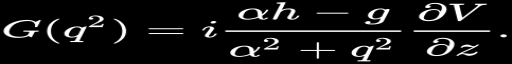

<S>G(q^{2})=i\frac{\alphah-g}{\alpha^{2}+q^{2}}\frac{\partialV}{\partialz}.<E><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P>


In [8]:

transform = transforms.ToPILImage()
display(transform(dataset.data_train[1][0]))
print(token_to_strings(dataset.data_train[1][1]))

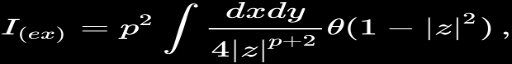

<S>I_{(ex)}=p^{2}\int\frac{dxdy}{4|z|^{p+2}}\theta(1-|z|^{2})\,,<E><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P>


In [9]:
transform = transforms.ToPILImage()
display(transform(dataset.data_val[10][0]))
print(token_to_strings(dataset.data_val[10][1]))

# Train 

In [11]:
# Initiate the model
model = ResNetTransformer(dataset=dataset).to(dev)

/Users/gregory/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gregory/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
torch.set_num_threads(1)
logger = TensorBoardLogger("Models_Parameters_Log", name="Test_Run")
lit_model = LitResNetTransformer(model=model)

#use the lit_model to run with Trainer
trainer = Trainer(accelerator="mps",   max_epochs=12, logger=logger,) #accumulate_grad_batches=2, overfit_batches=1, default_root_dir="lightning_logs/ResNet/checkpoints"  
trainer.fit(model=lit_model, datamodule=dataset,)

#add parameter below to trainer.fit to continue from a checkpoint
#ckpt_path='lightning_logs/Character_tokenizer_1/version_2/checkpoints/epoch=0-step=1294.ckpt'
 #ckpt_path='lightning_logs/Character_tokenizer_1/version_4/checkpoints/epoch=15-step=20704.ckpt' )

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
wandb: Currently logged in as: gmarus. Use `wandb login --relogin` to force relogin


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type               | Params
------------------------------------------------
0 | model    | ResNetTransformer  | 16.4 M
1 | loss_fn  | CrossEntropyLoss   | 0     
2 | val_cer  | CharacterErrorRate | 0     
3 | test_cer | CharacterErrorRate | 0     
------------------------------------------------
16.4 M    Trainable params
0         Non-trainable params
16.4 M    Total params
65.402    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/gregory/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/gregory/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.


In [13]:
# SAVING THE MODEL
torch.save(model.state_dict(), 'Models_Parameters_Log/first_test.pth')


In [14]:
import json

def save_dic(dic):
    filename = 'lightning_logs/256_character_1.json'
    with open(filename, 'w') as f:
        f.write(json.dumps(dic, default=str))

def load_dic(filename):
    with open(filename) as f:
        dic = json.loads(f.read())
    return dic

In [15]:
# Helper Function to convert prediction labels to strings
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s


# Inference Testing

## Test on validation set


Original image and formula:


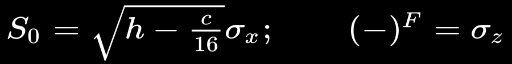

 <S> \begin{array} { l } { S _ { 0 } = \sqrt { h - \frac c { 1 6 } } \sigma _ { x } ; \qquad ( - ) ^ { F } = \sigma _ { z } } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>

Predicted formula: 

 <S> S _ { 0 } = \sqrt { h - \frac { c } { 1 6 } } \sigma _ { x } ; \qquad ( - ) ^ { F } = \sigma _ { z } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> 



<IPython.core.display.Math object>

None


In [43]:
# Get image and label from train data -- change number for different ones
image_tensor, label = dataset.data_val[12]
transform = transforms.ToPILImage()
image = transform(image_tensor)

print('\nOriginal image and formula:')
display(image)
print(token_to_strings(label))
print('\nPredicted formula: \n')
with torch.no_grad():
    model.to('cpu')
    model.eval()
    prediction =  model.predict(image_tensor.unsqueeze(0).to('cpu'))
print(token_to_strings(prediction),'\n')
print(display(Math(token_to_strings(prediction))))

## Test on random screenshots

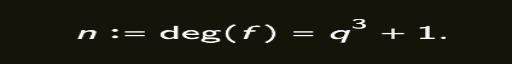

None

Predicted formula:
 <S> \qquad n : = \mathrm { d e g } ( f ) = q ^ { 2 } \star 1 . \qquad <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [42]:
my_image_path= "Jupyter_Notebooks/test_photos/my_image.png"
my_image = cv2.imread(my_image_path)
my_image =  cv2.cvtColor(my_image, cv2.COLOR_BGR2RGB)
my_image= cv2.bitwise_not(my_image)
#my_image = PIL.ImageOps.invert(my_image)

my_image_tensor = dataset.val_transform(image=np.array(my_image))['image']
print(display(transform(my_image_tensor)))
print('\nPredicted formula:')
with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(my_image_tensor.unsqueeze(0).to('cpu'))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

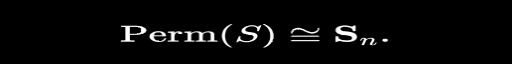

None

Predicted formula:
 <S> \qquad \mathrm { ~ p e r m } ( S ) \cong { \bf S } _ { n } , \qquad <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [45]:

my_image_path= "Jupyter_Notebooks/test_photos/zarhin.png"

my_image = cv2.imread(my_image_path)
my_image =  cv2.cvtColor(my_image, cv2.COLOR_BGR2RGB)
my_image= cv2.bitwise_not(my_image)
#my_image = PIL.ImageOps.invert(my_image)

my_image_tensor = dataset.val_transform(image=np.array(my_image))['image']
print(display(transform(my_image_tensor)))
print('\nPredicted formula:')
with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(my_image_tensor.unsqueeze(0).to('cpu'))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

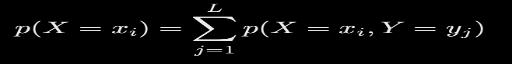

None

Predicted formula:
 <S> ~ ~ p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { d } p ( X = x _ { i , 1 } Y = y _ { j } ) ~ ~ ~ <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [47]:

my_image_path= "Jupyter_Notebooks/test_photos/screenshot_1.png"
my_image = cv2.imread(my_image_path)
my_image =  cv2.cvtColor(my_image, cv2.COLOR_BGR2RGB)
my_image= cv2.bitwise_not(my_image)
#my_image = PIL.ImageOps.invert(my_image)

my_image_tensor = dataset.val_transform(image=np.array(my_image))['image']
print(display(transform(my_image_tensor)))
print('\nPredicted formula:')
with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(my_image_tensor.unsqueeze(0).to('cpu'))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

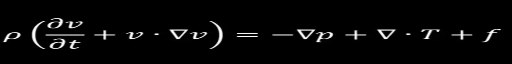

None

Predicted formula:
 <S> \rho \left( \frac { \partial x } { \partial t } + v \cdot \nabla v \right) = - \nabla p \star r + f <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [48]:
my_image_path= "Jupyter_Notebooks/test_photos/screenshot_3.png"
my_image = cv2.imread(my_image_path)
my_image =  cv2.cvtColor(my_image, cv2.COLOR_BGR2RGB)
my_image= cv2.bitwise_not(my_image)
#my_image = PIL.ImageOps.invert(my_image)

my_image_tensor = dataset.val_transform(image=np.array(my_image))['image']
print(display(transform(my_image_tensor)))
print('\nPredicted formula:')
with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(my_image_tensor.unsqueeze(0).to('cpu'))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

In [ ]:
my_image_path= "Jupyter_Notebooks/test_photos/screenshot_1.png"

In [ ]:
my_image_path= "Jupyter_Notebooks/test_photos/screenshot_3.png"